<img src="https://climate.nasa.gov/system/internal_resources/details/original/103_shutterstock_88550854-740px.jpg" width=90%>

# Introduction

Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.




# Imports

In [15]:
!pip install wordcloud

In [133]:
import numpy as np
import pandas as pd

'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline
# set plot style
sns.set()

'''Preprocessing'''
import nltk
import re
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer


from wordcloud import WordCloud
from sklearn import metrics
from sklearn.pipeline import Pipeline

'''classifier'''
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

'''Metrics/Evaluation'''
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score


In [134]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

# Exploratory Data Analysis

In this section of the nootebook we will explore the data given and visualize it to famaliarize ourselves with it.

### Getting the data

In [135]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

- Viewing the first rows in the datasets given.

In [136]:
df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [137]:
test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [138]:
sample.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,1


- Checking the keywords under each class for the train data

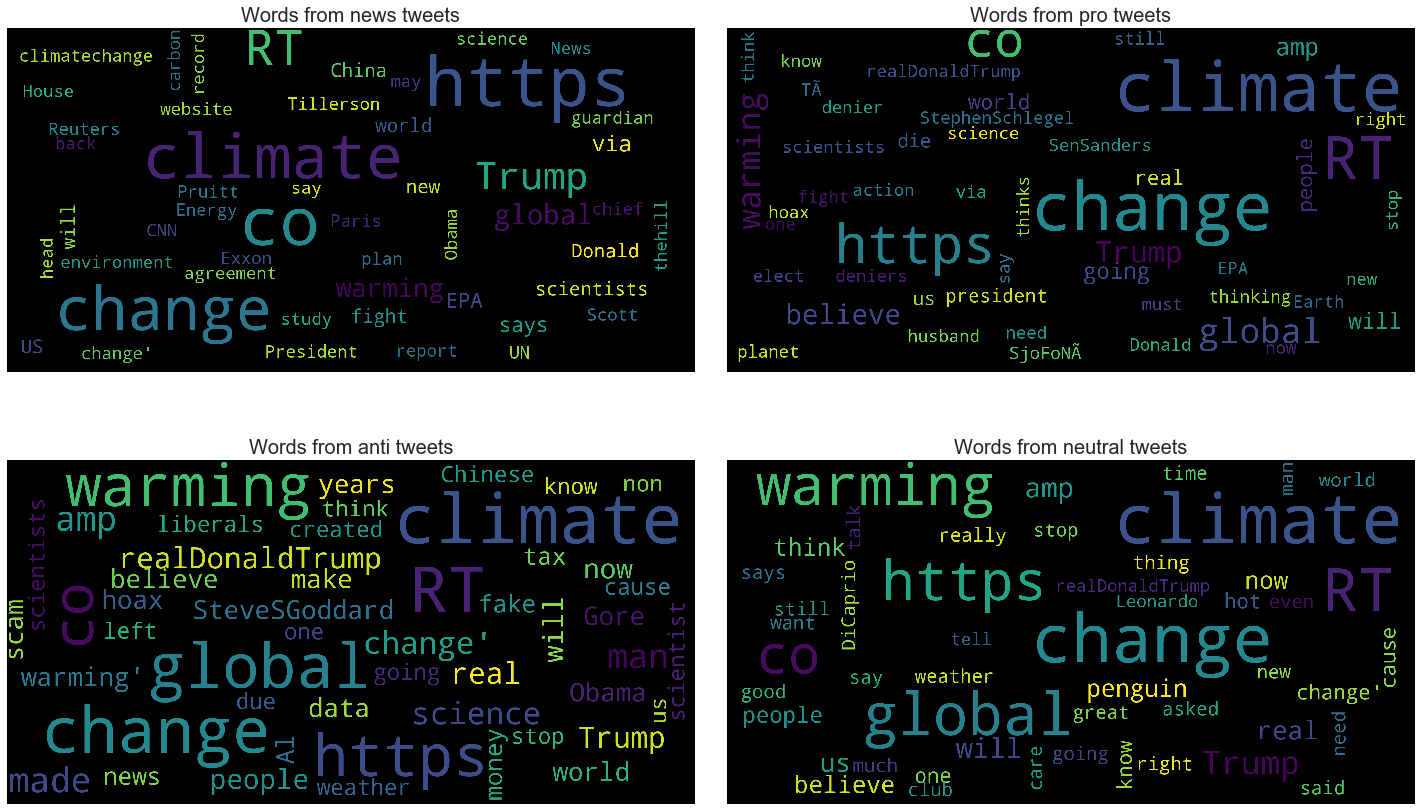

In [139]:
news = df[df['sentiment'] == 2]['message']
pro = df[df['sentiment'] == 1]['message']
neutral =df[df['sentiment'] == 0]['message']
Anti = df[df['sentiment'] ==-1]['message']


news = [word for line in news for word in line.split()]
pro = [word for line in pro for word in line.split()]
neutral = [word for line in neutral for word in line.split()]
Anti= [word for line in Anti for word in line.split()]

news = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40,
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(news))

pro = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40,
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(pro))



neutral = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40,
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(neutral))


Anti = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40,
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(Anti))


fig, axs = plt.subplots(2, 2, figsize = (20, 12))
# fig.suptitle('Clouds of polar words', fontsize = 30)
fig.tight_layout(pad = 0)

axs[0, 0].imshow(news)
axs[0, 0].set_title('Words from news tweets', fontsize = 20)
axs[0, 0].axis('off')
# axs[0, 0].tight_layout(pad = 1)

axs[0, 1].imshow(pro)
axs[0, 1].set_title('Words from pro tweets', fontsize = 20)
axs[0, 1].axis('off')
# axs[0, 1].tight_layout(pad = 1)


# axs[1, 0].tight_layout(pad = 1)
axs[1, 0].imshow(Anti)
axs[1, 0].set_title('Words from anti tweets', fontsize = 20)
axs[1, 0].axis('off')

axs[1, 1].imshow(neutral)
axs[1, 1].set_title('Words from neutral tweets', fontsize = 20)
axs[1, 1].axis('off')

# axs[1, 0].tight_layout(pad = 1)
plt.savefig('joint_cloud.png')

- The graph below shows the frequency of each sentiment in the train dataset(df).


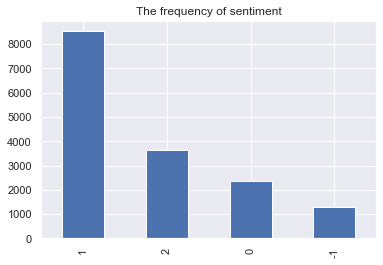

In [140]:
df['sentiment'].value_counts().plot(kind = 'bar')
plt.title ('The frequency of sentiment')
plt.show()


In [141]:
df.info() #getting some more in the train dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [142]:
# Checking Nulls in the dataframe
df.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

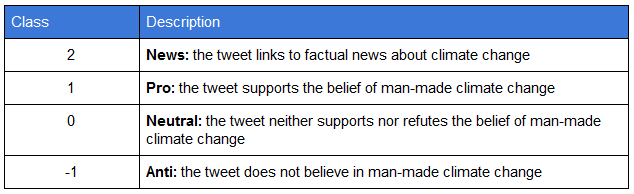






# Data Preprocessing

In this section will process and clean the data that will be used to create our model

- Checking for blanks in train dataset

In [143]:

blanks = []  # start with an empty list

for i,sen,mes,twe in df.itertuples():  # iterate over the DataFrame
    if type(mes)==str:            # avoid NaN values
        if mes.isspace():         # test 'review' for whitespace
            blanks.append(i)     # add matching index numbers to the list
        
print(len(blanks), 'blanks: ', blanks)

0 blanks:  []


## Text Cleaning

The function to pre-process the text in massage column of the dataframes. Tokenize, lower case, lemmatize, remove punctuation, numbers and stop words.

In [144]:
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub('<[^<]+?>','', text)
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

df['Processed_message'] = df.message.apply(lambda x: clean_text(x))

test['Processed_message'] = test.message.apply(lambda x: clean_text(x))


In [145]:
df.head()

,sentiment,message,tweetid,Processed_message
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...
1,1,It's not like we lack evidence of anthropogeni...,126103,like lack evidence anthropogenic global warm
2,2,RT @RawStory: Researchers say we have three ye...,698562,rt rawstory researcher say three year act clim...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,todayinmaker wire 2016 wa pivotal year war cl...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,rt soynoviodetodas 2016 racist sexist climate ...


In [146]:
#Making the tweetid to be the idex
test=test.set_index('tweetid')

In [147]:
test.head()

,message,Processed_message
tweetid,,
169760,Europe will now be looking to China to make su...,europe look china make sure alone fight climat...
35326,Combine this with the polling of staffers re c...,combine poll staffer climate change woman righ...
224985,"The scary, unimpeachable evidence that climate...",scary unimpeachable evidence climate change al...
476263,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,karoli morgfair osborneink dailykos \nputin ge...
872928,RT @FakeWillMoore: 'Female orgasms cause globa...,rt fakewillmoore female orgasm cause global wa...


# Model fitting

Here we will write some code to create the model to be deployed in Kaggle

In [148]:
#Defining the independent feature and the dependent feature
X=df['Processed_message'] #Independent features
y=df['sentiment'] #label
x_unseen=test['Processed_message'] #test independent feature

In [149]:
#Splitting the train dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### Pipelines for fttng the models

- 1st model

In [150]:
text_clf = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', 
                             min_df=1, 
                             max_df=0.9, 
                             ngram_range=(1, 2))),
                     ('clf',LogisticRegression()),
])
# Feed the training data through the pipeline
text_clf.fit(X_train, y_train)  

C:\Users\siyam\Anaconda3\New folder\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf', LogisticRegression())])

In [151]:
# Form a prediction set
predictions = text_clf.predict(X_test)
y_pred = text_clf.predict(x_unseen)

In [162]:
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

          -1       0.76      0.52      0.62       126
           0       0.64      0.39      0.49       224
           1       0.78      0.87      0.82       895
           2       0.72      0.78      0.75       337

    accuracy                           0.75      1582
   macro avg       0.73      0.64      0.67      1582
weighted avg       0.75      0.75      0.74      1582



In [163]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

0.7541087231352718


- 2nd model

In [164]:
text_clf1 = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', 
                             min_df=1, 
                             max_df=0.9, 
                             ngram_range=(1, 2))),
                     ('clf',LinearSVC()),
])
# Feed the training data through the pipeline
text_clf1.fit(X_train, y_train)  

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf', LinearSVC())])

In [177]:
# Form a prediction set
predictions1 = text_clf1.predict(X_test)
y_pred1 = text_clf1.predict(x_unseen)

In [176]:
print(metrics.classification_report(y_test, predictions1))

              precision    recall  f1-score   support

          -1       0.76      0.52      0.62       126
           0       0.64      0.39      0.49       224
           1       0.78      0.87      0.82       895
           2       0.72      0.78      0.75       337

    accuracy                           0.75      1582
   macro avg       0.73      0.64      0.67      1582
weighted avg       0.75      0.75      0.74      1582



In [178]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions1))

0.7541087231352718


- 3rd model

In [180]:
text_clf2 = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', 
                             min_df=1, 
                             max_df=0.9, 
                             ngram_range=(1, 2))),
                     ('clf', SVC(kernel='rbf')),
])
# Feed the training data through the pipeline
text_clf2.fit(X_train, y_train)  

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf', SVC())])

In [181]:
# Form a prediction set
predictions2 = text_clf2.predict(X_test)
y_pred = text_clf2.predict(x_unseen)

In [182]:
print(metrics.classification_report(y_test,predictions2))

              precision    recall  f1-score   support

          -1       0.89      0.31      0.46       126
           0       0.70      0.30      0.42       224
           1       0.72      0.93      0.81       895
           2       0.79      0.69      0.74       337

    accuracy                           0.74      1582
   macro avg       0.78      0.56      0.61      1582
weighted avg       0.75      0.74      0.71      1582



In [183]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions2))

0.7402022756005057


- 4th model

In [184]:
text_clf3 = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', 
                             min_df=1, 
                             max_df=0.9, 
                             ngram_range=(1, 2))),
                     ('clf', MultinomialNB()),
])
# Feed the training data through the pipeline
text_clf3.fit(X_train, y_train)  

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf', MultinomialNB())])

In [185]:
# Form a prediction set
predictions3 = text_clf3.predict(X_test)
y_pred = text_clf3.predict(x_unseen)

In [186]:
print(metrics.classification_report(y_test,predictions3))

              precision    recall  f1-score   support

          -1       1.00      0.05      0.09       126
           0       1.00      0.03      0.06       224
           1       0.62      0.99      0.76       895
           2       0.93      0.37      0.53       337

    accuracy                           0.65      1582
   macro avg       0.89      0.36      0.36      1582
weighted avg       0.77      0.65      0.56      1582



In [187]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions3))

0.6472819216182049


## Submissions

In [ ]:
submission.to_csv("TestSubmission7.csv",index  = False) #wrting csv file

# Conclusion

Here there will a conclusion on which model is fitted best and why